In [1]:
import os
import gc
import warnings
warnings.filterwarnings('ignore')

import glob
from shutil import copyfile, copy2

import pandas as pd
import numpy as np
from skimage import io

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold

In [2]:
# Lists and dictionaries that help make translating between class labels and mask colors easier
LABELS = ['Acrop', 'CCA', 'Macro', 'Monti', 'Off', 'Pavon', 'Pocill', 'Porit', 'Sand', 'Turf']


old_labels = pd.read_csv("Replace_With.csv")
old_labels = dict(zip(old_labels['Old'], old_labels['New']))

In [3]:
imgs = glob.glob("Data\\2008\\images\\*.jpg")
labs = glob.glob("Data\\2008\\cpce\\*.txt")

data = pd.DataFrame(data = list(zip(imgs, labs)), columns = ['images', 'cpce'])

dest = "Data\\2008\\patches_224"

for l in LABELS:
    if(not os.path.exists(dest + "\\" + l)):
        os.mkdir(dest + "\\" + l)

In [4]:
def crop_patch(image, y, x):

    size = 112
    
    patch = image[abs(size - y) : abs(size + y), abs(size - x) : abs(size + x), :]
    
    return patch


def check_dimensions(image, y, x):
    
    size = 224
    
    height, width = image.shape[0:2]
    if(x + (size//2) > width or x - (size//2) < 0 or y + (size//2) > height or y - (size//2) < 0):
        return False
    else:
        return True
    
    
def extract_patches(data):
    
    for i in range(len(data)):
        each_image = io.imread(data['images'][i])
        each_annotation = pd.read_csv(data['cpce'][i], sep = "; ", 
                                      engine = 'python').rename(columns={'# Row' : 'Y', 'Col': 'X'})
        

        each_annotation.replace(old_labels, inplace = True)   

        file_name = (data['cpce'][i].split("\\")[-1].split(".")[0]);

        height, width = each_image.shape[0:2]
        
        for index, row in each_annotation.iterrows():
            
            X = int(row[1])
            Y = int(row[0])
            L = str(row[2])
        
            
            if(L not in LABELS):
                continue
            
            if(check_dimensions(each_image, Y, X)):
                patch = crop_patch(each_image, Y, X)
              
            else:
                continue      

            io.imsave(arr = patch, fname = dest + "\\" + L +  "\\" + file_name + "_" + str(index) + ".png")
            
    print("Complete")       
    
extract_patches(data)

In [5]:
patches = glob.glob("Data\\2008\\patches_224\\**\\*.png", recursive = True)
labels = [patch.split("\\")[-2] for patch in patches]

data = pd.DataFrame(data = list(zip(patches, labels)), columns = ['images', 'labels'])
data = data[data['labels'] != 'Off']

In [6]:
# perform the split between training and validation
train, test = train_test_split(data, test_size = .2)
train, valid = train_test_split(train, test_size = .125)
print("Training:", len(train), "Validation:", len(valid), "Testing:", len(test))

Training: 90251 Validation: 12893 Testing: 25787


In [7]:
from panel_image import *
from keras.preprocessing.image import ImageDataGenerator

batch_size = 32

# Training images are augmented, and then lightly pre-processed
train_augmentor = ImageDataGenerator(preprocessing_function = panel, 
                                            horizontal_flip = True, 
                                            vertical_flip = True)      
                                     
                                                                   
# Reading from dataframe, can save augmented images if needed
train_generator = train_augmentor.flow_from_dataframe(dataframe = train, directory = None,
                                                      x_col = 'images', y_col = 'labels', target_size = (224, 224), 
                                                      color_mode = "rgb",  class_mode = 'categorical', 
                                                      batch_size = batch_size, shuffle = True, seed = 42)
                                                     

# Only pre-process images, no augmentation
validate_augmentor = ImageDataGenerator( preprocessing_function = panel)


# Reading from dataframe                             
validation_generator = validate_augmentor.flow_from_dataframe(dataframe = valid, directory = None, 
                                                              x_col = 'images', y_col = 'labels', target_size = (224, 224), 
                                                              color_mode = "rgb",  class_mode = 'categorical', 
                                                              batch_size = batch_size, shuffle = True, seed = 42)

Using TensorFlow backend.


Found 90251 images belonging to 9 classes.
Found 12893 images belonging to 9 classes.


In [8]:
num_epochs = 25

# Defines the length of an epoch, all images used
steps_per_epoch_train = len(train)/batch_size

# Defines the length of an epoch, all images used
steps_per_epoch_valid = len(valid)/batch_size

In [9]:
# Transfer-learning model
from keras.models import Model
#from keras.applications.nasnet import NASNetMobile
from efficientnet.keras import EfficientNetB0
from keras.layers import Input, Dense, BatchNormalization, Activation, Dropout

main_input = Input(shape = (224, 224, 3))
#base = NASNetMobile(include_top = False, weights = 'imagenet', pooling = 'max')(main_input)
base = EfficientNetB0(include_top = False, weights = 'noisy-student', pooling = 'max')(main_input)
x = Dropout(.75)(base)
x = Dense(9)(x)
main_output = Activation('softmax')(x)

model = Model(inputs = [main_input], outputs = [main_output])

Instructions for updating:
Shapes are always computed; don't use the compute_shapes as it has no effect.


In [10]:
from keras import optimizers

learning_rate = 0.00025

model.compile(loss = 'categorical_crossentropy',
              optimizer = optimizers.Adam(lr = learning_rate), 
              metrics = ['acc'])

In [11]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler

holla = [
         LearningRateScheduler(reduceLR),
         ModelCheckpoint(filepath = "Experiment_1\\Panel.h5", 
                         monitor = 'val_loss', 
                         save_weights_only = True, 
                         save_best_only = True, verbose = 1)
        ]

In [12]:
# Starts training, saves info for later
history = model.fit_generator(train_generator, 
                              steps_per_epoch = steps_per_epoch_train, 
                              epochs = num_epochs, 
                              validation_data = validation_generator, 
                              validation_steps = steps_per_epoch_valid,
                              callbacks = holla,
                              verbose = 1)  

Epoch 1/25
New Learning Rate: 0.00025
2821/2820 [==============================] - 1725s 611ms/step - loss: 1.4884 - acc: 0.6902 - val_loss: 0.5791 - val_acc: 0.8009

Epoch 00001: val_loss improved from inf to 0.57907, saving model to Experiment_1\Panel.h5
Epoch 2/25
New Learning Rate: 0.00022727
2821/2820 [==============================] - 1738s 616ms/step - loss: 0.7457 - acc: 0.7704 - val_loss: 0.5278 - val_acc: 0.8120

Epoch 00002: val_loss improved from 0.57907 to 0.52784, saving model to Experiment_1\Panel.h5
Epoch 3/25
New Learning Rate: 0.00018939
2821/2820 [==============================] - 1737s 616ms/step - loss: 0.6414 - acc: 0.7933 - val_loss: 0.5065 - val_acc: 0.8205

Epoch 00003: val_loss improved from 0.52784 to 0.50654, saving model to Experiment_1\Panel.h5
Epoch 4/25
New Learning Rate: 0.00014569
2821/2820 [==============================] - 1752s 621ms/step - loss: 0.5777 - acc: 0.8084 - val_loss: 0.5133 - val_acc: 0.8272

Epoch 00004: val_loss did not improve from 0.

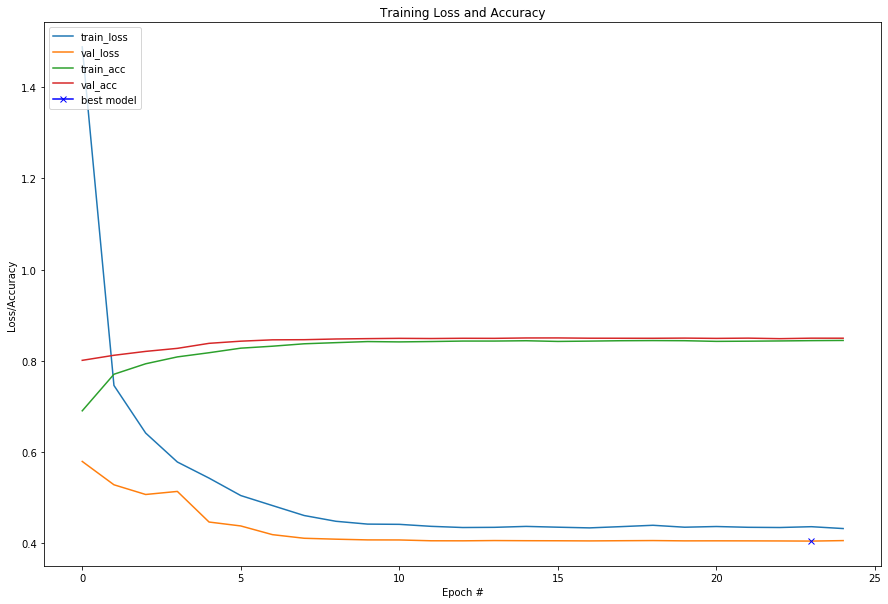

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize = (15, 10))
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.plot(history.history["acc"], label="train_acc")
plt.plot(history.history["val_acc"], label="val_acc")

plt.plot(np.argmin(history.history["val_loss"]), 
         np.min(history.history["val_loss"]), 
         marker = "x", color = "b", label = "best model")

plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left")
plt.show()

In [15]:
model.load_weights("Experiment_1\\Panel.h5")

In [17]:
# Reads from dataframe for holdout set
test_generator = validate_augmentor.flow_from_dataframe(dataframe = test,
                                                 x_col = 'images', y_col = 'labels', target_size = (224, 224), 
                                                 color_mode = "rgb",  class_mode = 'categorical', 
                                                 batch_size = batch_size, shuffle = False, seed = 42)
# Defines the length of an epoch
steps_per_epoch_test = len(test)/batch_size

Found 25787 images belonging to 9 classes.


In [18]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.model_selection import cross_val_score

predictions = model.predict_generator(test_generator, steps = steps_per_epoch_test)
predict_classes = np.argmax(predictions, axis = 1)

test_y = test_generator.classes
print("# of images:", len(predict_classes))
print(accuracy_score(y_true = test_y, y_pred = predict_classes))
print(confusion_matrix(y_true = test_y, y_pred = predict_classes))

# of images: 25787
0.8442626129445069
[[  224    20     2     6     1    26     3     0     5]
 [    4 11294   191    40    35    43    93   270   596]
 [    1   320  1359     3     6    10     8     6    56]
 [    2   103     4   594     0     3     8     6     5]
 [    1    34     6     3   320     1     2     1     2]
 [   14    73     5     3     3  1338     4     0    16]
 [    1   158     7     8     8     5  2481    18    26]
 [    0   291     1    13     2     0    25  2341    89]
 [    4  1049    58     7     6    10    45   141  1820]]
